# Calculate velocity errors over stable surfaces (stable surface error) for all velocity maps in a folder

Generates a table with all velocity map information, including the stable surface error.

By Jukes Liu

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import fiona
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import mapping

### Set paths to velocity maps, the stable surface masks (ssm), and a glacier shapefile (UTM projection)

In [2]:
# path to autorift velocity maps:
autorift_outp = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/output_AutoRIFT/'

# set path to folder with the stable surface mask (should have been generated when running custom autoRIFT)
# contains files named ssm_#m.tif
refvpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/forAutoRIFT/'
print(os.listdir(refvpath))

# read in glacier shapefile and grab outline as shapes
shp_path = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/Turner_RGI/TG_glims_polygon_UTM7.shp'
with fiona.open(shp_path) as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

['TG_mask_ST_350m.tif', 'ice_mask_200mbuffer.tif', 'TG_mask_MT_150m.tif', 'vy_50m.tif', 'TG_mask_NT_200m.tif', 'TG_mask_350m.tif', 'srx_400m.tif', 'sry_400m.tif', 'ssm_400m.tif.aux.xml', 'main_glacier_mask_2m.tif', 'TG_mask_NT.tif', 'vy_200m.tif', 'vx_200m.tif', '.DS_Store', 'vx_cropped.tif', 'sry_175m.tif', 'srx_175m.tif', 'TG_mask_MT_350m.tif', 'TG_mask_ST_150m.tif', 'vx_50m.tif', 'TG_mask_150m.tif', 'csminy_200m.tif', 'csminx_200m.tif', 'ssm_200m.tif', 'vx_5m.tif', 'csmaxy_300m.tif', 'csmaxx_300m.tif', 'sry_50m.tif', 'IfSAR_DSM_5m_cropped.vrt', 'Turner_mask.prj', 'srx_5m.tif', 'TG_mask_MT_160m.tif', 'TG_mask_NT_400m.tif', 'TG_mask_100m.tif', 'csmaxy_160m.tif', 'csmaxx_160m.tif', 'srx_200m.tif', 'sry_200m.tif', 'forAutoRIFT.0.tif.aux.xml', 'vx_175m.tif', 'vy_175m.tif', 'TG_mask_ST_100m.tif', 'TG_mask_MT_300m.tif', 'dhdx_cropped.tfw', 'ssm_400m.tif', 'csminy_400m.tif', 'csminx_400m.tif', 'TG_mask_300m.tif', 'TG_mask_MT_100m.tif', 'dhdx_cropped.tif', 'TG_mask_ST_300m.tif', 'Turner_mask

### Grab important information and SSE from each velocity map

In [8]:
# initialize lists to store info for each velocity map
ds1s = []; ds2s = []; dts = []; chipsizes = []; sats = []; data_fracs = []; err_vx = []; err_vy = []; err_v = []; 
file_count = 0

# for each velocity map
for output in os.listdir(autorift_outp):
    if output.startswith('velocity') and output.endswith('.tif'):
        print(output) # display file names
        [filetype, ds1, ds2, chipsize, sat] = output.split('_') # grab info from filename
        d1 = datetime.datetime.strptime(ds1, '%Y%m%d'); d2 = datetime.datetime.strptime(ds2, '%Y%m%d')
        dt = d2-d1
        sat = sat.split('.')[0] # s
        ds1s.append(ds1); ds2s.append(ds2); dts.append(dt.days)
        chipsizes.append(int(chipsize[:-1])); sats.append(sat)
        
        # read in the velocity map
        v_reader = rio.open(autorift_outp+output)
        vx = v_reader.read(1); vy = v_reader.read(2) # grab vx and vy
        v = np.sqrt(vx**2 + vy**2) # calculate vmag from vx and vy
        # raster grid value (UTM coordinates)
        x_vals = np.arange(v_reader.bounds.left, v_reader.bounds.right+1, v_reader.transform[0])
        y_vals = np.arange(v_reader.bounds.bottom, v_reader.bounds.top+1, v_reader.transform[0])
        
        # Read in stable surface mask
        ssm_reader = rio.open(refvpath+'ssm_'+chipsize+'.tif') # stable surface mask
        ssm = ssm_reader.read(1)
        if ssm.shape != vx.shape:
            ssm = ssm[:vx.shape[0],:vx.shape[1]]
        
        # grab data fraction in glacier outline
        cropped_img, cropped_transform = mask(v_reader, shapes, nodata= -3e5, crop=True)
        if cropped_img.shape[0] == 3:
            cropped_v = cropped_img[2] # grab the third band [2]
        else:
            cropped_vx = cropped_img[0]; cropped_vy = cropped_img[1]
            cropped_v = np.sqrt(cropped_vx**2 + cropped_vy**2) 
        cropped_v_filled = cropped_v.copy()
        cropped_v_filled[np.isnan(cropped_v_filled)] = 0 # fill all Nans with 0
        total_pixels = np.count_nonzero(cropped_v_filled >= 0) # count number of non-nodata values (negative)
        cropped_v[cropped_v < 0] = np.NaN # turn no data values (negative) into NaNs
        pixels_w_data = len(cropped_v[cropped_v >= 0]) # count non Nans (number of pixels with data)
        if pixels_w_data > 0:
            data_percent = int(pixels_w_data/total_pixels*100)
            data_fracs.append(data_percent)
            empty = False
        else:
            data_fracs.append(0)
            empty = True
#         plt.imshow(cropped_v); plt.colorbar(); plt.title(str(data_percent)+' %'); plt.show() # check visually
            
        # Grab off-ice velocities using stable surface mask
        ssm[ssm > 0] = 2 # turn ice into 2
        ssm[ssm == 0] = 1 # turn stable surfaces into 1
        ssm[ssm == 2] = 0 # turn ice into 0s
        ssm_masked_vx = ssm*vx; ssm_masked_vy = ssm*vy; ssm_masked_v = ssm*v 
        
        # calculate RMSE [m/d]
        err_vx.append(np.sqrt(np.nanmean(ssm_masked_vx**2))/365)
        err_vy.append(np.sqrt(np.nanmean(ssm_masked_vy**2))/365)
        err_v.append(np.sqrt(np.nanmean(ssm_masked_v**2))/365)
        
        # get ready for next iteration
        del v, vx, vy, empty
        file_count += 1
        
print(file_count, 'files found.')

velocity_20190327_20190401_160m_S2.tif
velocity_20150515_20150522_300m_LS.tif
velocity_20220519_20220522_200m_S2.tif
velocity_20200402_20200405_300m_S2.tif
velocity_20180516_20180531_200m_S2.tif
velocity_20170416_20170423_100m_S2.tif
velocity_20171104_20171109_300m_S2.tif
velocity_20190804_20190809_200m_S2.tif
velocity_20170423_20170506_300m_S2.tif
velocity_20180401_20180411_300m_S2.tif
velocity_20191008_20191013_100m_S2.tif
velocity_20190705_20190710_160m_S2.tif
velocity_20200729_20200818_200m_S2.tif
velocity_20150725_20150803_160m_LS.tif
velocity_20200311_20200323_160m_S2.tif
velocity_20180702_20180720_100m_S2.tif
velocity_20190610_20190613_50m_PS.tif
velocity_20161024_20170220_100m_LS.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_55042/1295633843.py:58: RuntimeWarning: Mean of empty slice
  err_vx.append(np.sqrt(np.nanmean(ssm_masked_vx**2))/365)
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_55042/1295633843.py:59: RuntimeWarning: Mean of empty slice
  err_vy.append(np.sqrt(np.nanmean(ssm_masked_vy**2))/365)
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_55042/1295633843.py:60: RuntimeWarning: Mean of empty slice
  err_v.append(np.sqrt(np.nanmean(ssm_masked_v**2))/365)


velocity_20200604_20200609_200m_S2.tif
velocity_20180416_20180506_300m_S2.tif
velocity_20191013_20191020_160m_S2.tif
velocity_20190426_20190501_200m_S2.tif
velocity_20210815_20210830_300m_S2.tif
velocity_20170712_20171028_300m_S2.tif
velocity_20220409_20220412_100m_S2.tif
velocity_20190905_20190915_100m_S2.tif
velocity_20171109_20171114_300m_S2.tif
velocity_20130617_20130712_300m_LS.tif
velocity_20160314_20160321_100m_LS.tif
velocity_20200609_20200626_200m_S2.tif
velocity_20220326_20220331_300m_S2.tif
velocity_20180329_20180411_100m_S2.tif
velocity_20210609_20210614_200m_S2.tif
velocity_20200626_20200701_100m_S2.tif
velocity_20190915_20191003_300m_S2.tif
velocity_20210701_20210704_200m_S2.tif
velocity_20140901_20140924_200m_LS.tif
velocity_20220629_20220703_200m_S2.tif
velocity_20200515_20200527_100m_S2.tif
velocity_20150522_20150531_200m_LS.tif
velocity_20200510_20200515_100m_S2.tif
velocity_20190722_20190730_100m_S2.tif
velocity_20200417_20200420_200m_S2.tif
velocity_20161008_2016102

velocity_20180416_20180506_200m_S2.tif
velocity_20210704_20210716_160m_S2.tif
velocity_20170526_20170602_100m_S2.tif
velocity_20210716_20210719_100m_S2.tif
velocity_20180329_20180401_160m_S2.tif
velocity_20200701_20200716_160m_S2.tif
velocity_20190426_20190501_300m_S2.tif
velocity_20210815_20210830_200m_S2.tif
velocity_20170712_20171028_200m_S2.tif
velocity_20171109_20171114_200m_S2.tif
velocity_20130617_20130712_200m_LS.tif
velocity_20180903_20180912_100m_LS.tif
velocity_20180516_20180531_300m_S2.tif
velocity_20190401_20190413_100m_S2.tif
velocity_20220519_20220522_300m_S2.tif
velocity_20150515_20150522_200m_LS.tif
velocity_20200402_20200405_200m_S2.tif
velocity_20140731_20140823_100m_LS.tif
velocity_20190804_20190809_300m_S2.tif
velocity_20170423_20170506_200m_S2.tif
velocity_20200323_20200326_100m_S2.tif
velocity_20180401_20180411_200m_S2.tif
velocity_20171104_20171109_200m_S2.tif
velocity_20140325_20140401_160m_LS.tif
velocity_20200729_20200818_300m_S2.tif
velocity_20200505_2020051

velocity_20210614_20210619_100m_S2.tif
velocity_20160508_20160609_200m_LS.tif
velocity_20200527_20200604_200m_S2.tif
velocity_20170705_20170712_160m_S2.tif
velocity_20220512_20220515_200m_S2.tif
velocity_20150623_20150709_160m_LS.tif
velocity_20180913_20180918_300m_S2.tif
velocity_20180919_20190210_300m_LS.tif
velocity_20190906_20190915_200m_LS.tif
velocity_20170511_20170527_300m_LS.tif
velocity_20190905_20190908_200m_S2.tif
velocity_20160828_20160929_300m_LS.tif
velocity_20210830_20210907_100m_S2.tif
velocity_20220419_20220430_200m_S2.tif
velocity_20170602_20170705_160m_S2.tif
velocity_20220708_20220729_200m_S2.tif
velocity_20210422_20210425_200m_S2.tif
velocity_20180329_20180411_300m_S2.tif
velocity_20220326_20220331_100m_S2.tif
velocity_20190624_20190714_50m_PS.tif
velocity_20200626_20200701_300m_S2.tif
velocity_20190915_20191003_100m_S2.tif
velocity_20200510_20200515_300m_S2.tif
velocity_20180506_20180516_200m_S2.tif
velocity_20190722_20190730_300m_S2.tif
velocity_20190606_20190610

velocity_20190513_20190607_200m_S2.tif
velocity_20190908_20190915_100m_S2.tif
velocity_20190501_20190513_160m_S2.tif
velocity_20140503_20140604_200m_LS.tif
velocity_20200330_20200402_200m_S2.tif
velocity_20190207_20190212_100m_S2.tif
velocity_20190630_20190705_100m_S2.tif
velocity_20220515_20220519_300m_S2.tif
velocity_20220109_20220112_100m_S2.tif
velocity_20220611_20220616_300m_S2.tif
velocity_20190330_20190415_100m_LS.tif
velocity_20200405_20200410_300m_S2.tif
velocity_20220301_20220306_300m_S2.tif
velocity_20210524_20210601_200m_S2.tif
velocity_20170506_20170526_300m_S2.tif
velocity_20150531_20150623_200m_LS.tif
velocity_20180210_20180217_100m_S2.tif
velocity_20190226_20190307_200m_LS.tif
velocity_20220608_20220611_100m_S2.tif
velocity_20130728_20130813_200m_LS.tif
velocity_20181008_20181102_200m_S2.tif
velocity_20191025_20191109_300m_S2.tif
velocity_20190210_20190215_200m_S2.tif
velocity_20140228_20140325_100m_LS.tif
velocity_20150506_20150515_160m_LS.tif
velocity_20220117_2022020

velocity_20180329_20180401_200m_S2.tif
velocity_20191013_20191020_300m_S2.tif
velocity_20220623_20220626_100m_S2.tif
velocity_20210704_20210716_200m_S2.tif
velocity_20180416_20180506_160m_S2.tif
velocity_20190730_20190804_100m_S2.tif
velocity_20190513_20190607_300m_S2.tif
velocity_20200116_20200202_200m_S2.tif
velocity_20190625_20190630_200m_S2.tif
velocity_20180831_20180903_100m_S2.tif
velocity_20200330_20200402_300m_S2.tif
velocity_20130610_20130617_100m_LS.tif
velocity_20140503_20140604_300m_LS.tif
velocity_20160929_20161008_100m_LS.tif
velocity_20210719_20210729_160m_S2.tif
velocity_20220129_20220201_100m_S2.tif
velocity_20180913_20180918_100m_S2.tif
velocity_20210803_20210815_200m_S2.tif
velocity_20220306_20220320_200m_S2.tif
velocity_20180908_20180913_100m_S2.tif
velocity_20140410_20140426_160m_LS.tif
velocity_20190821_20190830_300m_LS.tif
velocity_20190710_20190722_100m_S2.tif
velocity_20180930_20181008_300m_S2.tif
velocity_20210614_20210619_300m_S2.tif
velocity_20220214_2022021

In [9]:
df = pd.DataFrame(list(zip(ds1s, ds2s, chipsizes, sats, dts, data_fracs, err_vx, err_vy, err_v)),
                 columns=['ds1','ds2','min_chip_size','sat','dt_days','data_percent',
                          'err_vx','err_vy','err_v'])
df.sort_values(by=['ds1','min_chip_size','sat'])
df

,ds1,ds2,min_chip_size,sat,dt_days,data_percent,err_vx,err_vy,err_v
0,20190327,20190401,160,S2,5,97,0.060632,0.514467,0.518027
1,20150515,20150522,300,LS,7,99,0.318886,0.204550,0.378852
2,20220519,20220522,200,S2,3,33,0.270222,0.593957,0.652537
3,20200402,20200405,300,S2,3,91,0.714413,0.294911,0.772889
4,20180516,20180531,200,S2,15,96,0.198815,0.067081,0.209827
...,...,...,...,...,...,...,...,...,...
927,20220117,20220202,200,LS,16,72,0.343490,0.428565,0.549229
928,20181008,20181102,300,S2,25,53,0.194189,0.063969,0.204454
929,20190829,20190905,160,S2,7,99,0.411076,0.162019,0.441853
930,20191025,20191109,200,S2,15,79,0.045898,0.052285,0.069573


In [14]:
# convert dates to datetime objects
df.ds1 = pd.to_datetime(df.ds1, format='%Y%m%d')
df.ds2 = pd.to_datetime(df.ds2, format='%Y%m%d')
df['mid_date'] = (df.ds2-df.ds1)/2+df.ds1
df

,ds1,ds2,min_chip_size,sat,dt_days,data_percent,err_vx,err_vy,err_v,mid_date
0,2019-03-27,2019-04-01,160,S2,5,97,0.060632,0.514467,0.518027,2019-03-29 12:00:00
1,2015-05-15,2015-05-22,300,LS,7,99,0.318886,0.204550,0.378852,2015-05-18 12:00:00
2,2022-05-19,2022-05-22,200,S2,3,33,0.270222,0.593957,0.652537,2022-05-20 12:00:00
3,2020-04-02,2020-04-05,300,S2,3,91,0.714413,0.294911,0.772889,2020-04-03 12:00:00
4,2018-05-16,2018-05-31,200,S2,15,96,0.198815,0.067081,0.209827,2018-05-23 12:00:00
...,...,...,...,...,...,...,...,...,...,...
927,2022-01-17,2022-02-02,200,LS,16,72,0.343490,0.428565,0.549229,2022-01-25 00:00:00
928,2018-10-08,2018-11-02,300,S2,25,53,0.194189,0.063969,0.204454,2018-10-20 12:00:00
929,2019-08-29,2019-09-05,160,S2,7,99,0.411076,0.162019,0.441853,2019-09-01 12:00:00
930,2019-10-25,2019-11-09,200,S2,15,79,0.045898,0.052285,0.069573,2019-11-01 12:00:00


### Export CSV to a file

In [15]:
outfilepath = '' # enter path and name of CSV file to save to
df.to_csv(outfilepath)

FileNotFoundError: [Errno 2] No such file or directory: ''

## Plot errors

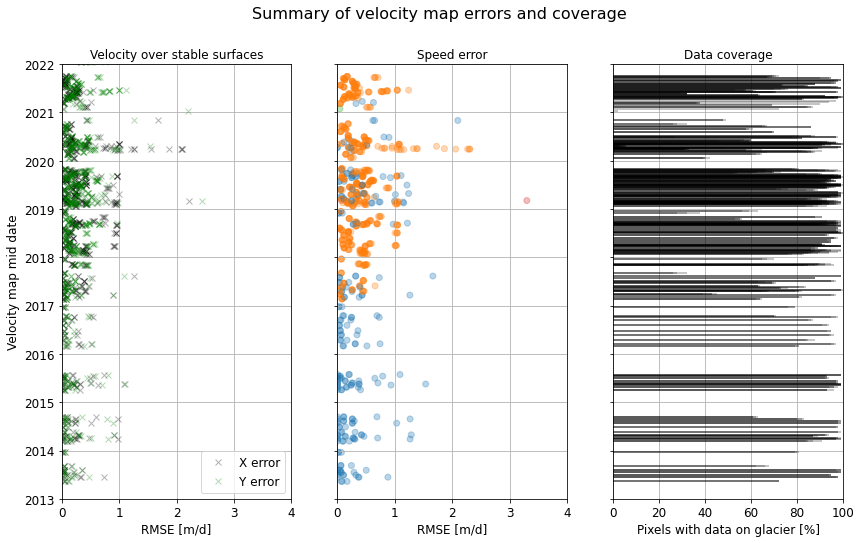

In [50]:
# create subplots with common y-axis
fs = 12
a = 0.3 # control opacity
colors_dict = {'LS':'tab:blue', 'S2':'tab:orange', 'S1':'tab:green', 'PS':'tab:red'}
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,8), sharey=True)

# 1) plot velocity residuals over stable surfaces
ax1.set_title("Velocity over stable surfaces", fontsize=fs)
ax1.plot(df.err_vx,df.mid_date, 'kx', alpha=a)
ax1.plot(df.err_vy,df.mid_date, 'gx', alpha=a)
ax1.set_xlim(0, 4)
ax1.set_xlabel('RMSE [m/d]', fontsize=fs); ax1.set_ylabel('Velocity map mid date', fontsize=fs);
ax1.legend(['X error','Y error'], loc='lower right', fontsize=fs)

# 2) plot speed residual of stable surfaces (scaled by max speed)
ax2.set_title("Speed error", fontsize=fs)
ax2.scatter(df.err_v, df.mid_date, c=df.sat.map(colors_dict), alpha=a) # color points by satellite (see colors dict)
ax2.set_xlim(0,4)
ax2.set_xlabel('RMSE [m/d]', fontsize=fs);

# 3) percent coverage on glacier
ax3.set_title("Data coverage")
ax3.hlines(df.mid_date, np.zeros(len(df.data_percent)),df.data_percent, color='k',alpha=a)
ax3.set_xlabel('Pixels with data on glacier [%]', fontsize=fs)
ax3.set_xlim(0,100)

# all plots
for ax in [ax1, ax2, ax3]:
    ax.tick_params(labelsize=fs)
    ax.grid()
    ax.set_ylim(datetime.datetime(2013,1,1), datetime.datetime(2022,1,1))

plt.suptitle('Summary of velocity map errors and coverage', fontsize=fs+4)
plt.show()